# Copolymerization

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/HugoMVale/polykin/main?labpath=docs%2Ftutorials%2Fcopolymerization.ipynb)

## Overview

The `polykin.copolymerization` module offers a number of classes to analyze copolymerization behavior and fit experimental copolymerization data.

## Terminal Model

In [1]:
from polykin.copolymerization import TerminalCopoModel

The terminal model of copolymerization is the most well-known and widely used among all copolymerization models. For this tutorial, we will employ it to analyze the behavior of the butyl acrylate and styrene system, using parameters from the literature.

In [2]:
model = TerminalCopoModel(r1=0.16, r2=0.70, M1='BA', M2='ST', name='BA/ST, 50°C')

In [3]:
model

name: BA/ST, 50°C
M1:   BA
M2:   ST
r1:   0.16
r2:   0.7

### Azeotropic composition

Since both reactivity ratios are less than 1, this system exhibits an azeotrope, and its composition can be determined using the `azeo` property.

In [4]:
model.azeo

0.2631578947368421

### Instantaneous copolymer composition

The instantaneous copolymer composition corresponding to a given comonomer composition can be calculated with the method `F1()`. Let's confirm the azeotrope is really an azeotrope.

In [5]:
model.F1(model.azeo)

0.2631578947368421

The relationship between comonomer composition and and instantaneous copolymer composition can be plotted with the method `plot()`. 

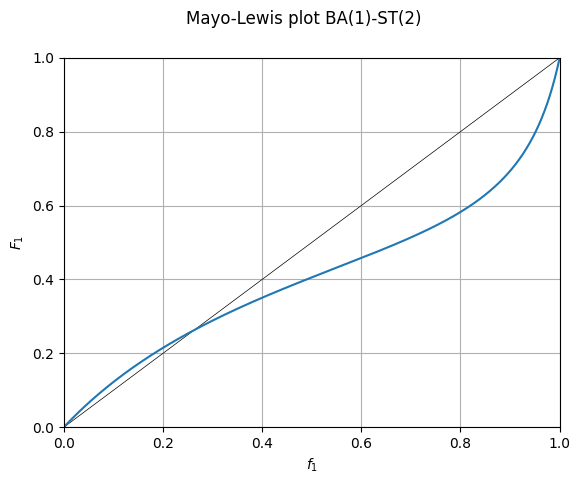

In [6]:
model.plot()

To generate the plot in terms of the composition of monomer 2, it suffices to set `M=2`.

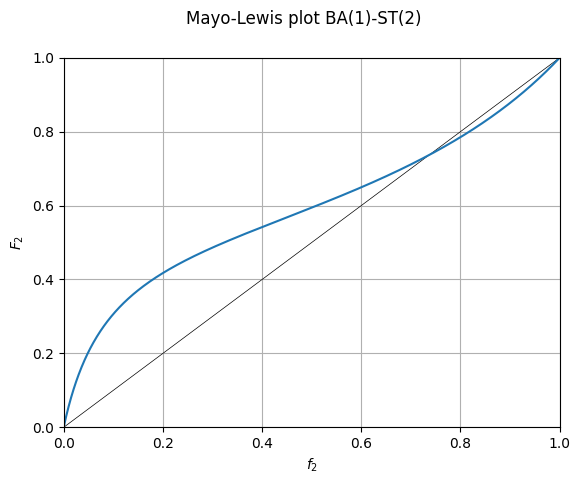

In [7]:
model.plot(M=2)

### Composition drift

When copolymerizing two monomers with different reactivities in a closed system, there is a preferential consumption of the more reactive monomer, leading to a change in composition known as _drift_. This drift can be calculated using the `drift()` method, which requires two mandatory arguments: the initial composition `f10` and the total monomer conversion `x`. The solution is obtained through direct numerical integration.

In [8]:
model.drift(f10=0.5, x=[0.50, 0.98]) # f10 and x can be scalars or array-like

array([[0.57768205, 0.99981396]])

To visualize the composition drift, we can use the previously mentioned `plot()` method by passing the initial monomer composition(s) as the argument `f0`.

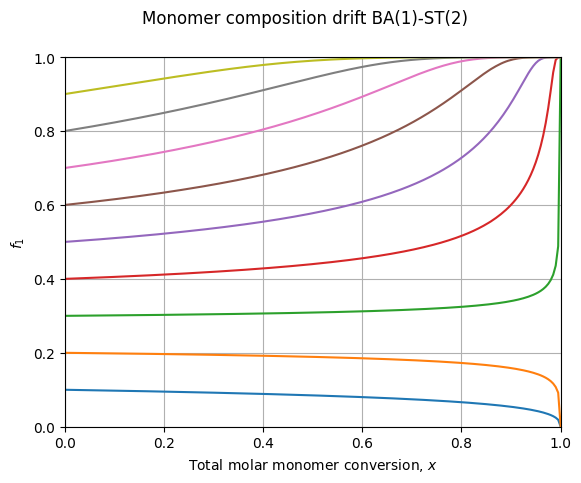

In [9]:
model.plot(f0=[0.1 + i*0.1 for i in range(10)], M=1)